# 10/29/2020

This will be a tutorial on Gibbs sampling implemented on an example of a Gaussian mixture model. I intend to cover three main examples:

1. Gibbs sampling for a two-component, univariate Gaussian mixture 
2. Gibbs sampling for a $K$-component, univariate Gaussian mixture 
3. Gibbs sampling for a $K$-component, multivariate Gaussian mixture

### Building the joint distribution 

When we speak of a probabilistic model for this data, we are referring specifically to the *joint distribution* of all quantities: $$ p\left(x^{1:N}, z^{1:N}, \theta\right) $$

To come up with this joint distribution, let's think about how the data itself might have been generated or, at least, how we may imagine generating similar data, ourselves.

When we want to generate a new observation, say $x^{N+1}$, we first randomly choose a mixture component $z^{N+1}$ for the observation to be drawn from. The mixture component may be drawn from some distribution $$ z \sim p\left(z|\theta_z\right) $$ where $\theta_z$ is some parameter (or set thereof) which helps define this distribution. For instance, if we postulate that the mixture assignment is drawn from a normal distribution, i.e., that $p\left(z|\theta_z\right) = \mathcal{N}\left(\mu_z,\sigma^2_z\right)$, then we would write $\theta_z = \left(\mu_z, \sigma_z\right)$.

In typical treatments of the Gaussian mixture model, this distribution over mixture assignments is usually taken as a categorical distribution over the possible components. In the case of two components, this is simply $$ p\left(z|\theta_z\right) = \left\{ \begin{array}{rl} \pi, & z=0 \\ 1-\pi, & z=1 \end{array} \right. $$ Note that in this simple situation we have $\theta_z = \pi$; that is, the probability of an observation coming from the first component (component $0$) is $\pi$, and the probability of coming from the second component is thus $1-\pi$. Of course, we don't know the possible values of $\pi$, and inferring it from the data is the point of inference.



Once a mixture component $z^{N+1}$ has been assigned for the new observation, the observation $x^{N+1}$ itself is drawn from some distribution, $$ x \sim p\left(x|z,\theta\right) $$ where $\theta$ incorporates both $\theta_z$ and other parameters. This distribution is sometimes referred to as the *observed data likelihood* since it describes the likelihood of observing various values of $x$ given a particular mixture component and the parameters of that mixture component. In a Gaussian mixture model, this observed data likelihood is always taken to be a Gaussian: $$ p\left(x|z,\theta\right) = \frac{1}{\sqrt{2\pi}\sigma_z^2} \exp \left( -\frac{1}{2\sigma_z^2} \left(x - \mu_z \right)^2\right) $$ where $\mu_z,\sigma_z^2 \in \theta$ are the mean and variance of the $z$-th component of the mixture, and are parameters which we seek to infer from the observed data. 

Note that in the case of two Gaussian components, we will represent these two densities using an abbreviated notation: $$ p\left(x|z=0,\theta_0\right) := \phi_0\left(x\right) $$ and similarly for the second component.

Assumme that we followed this data generating process and generated both an assignment variable $z$ and an observation $x$. Both constitute the data in this problem, and so it makes sense to look at the *total data likelihood*, $$ p\left(x,z|\theta\right)$$ which, thanks to the basic definition of conditional probability, can be factored as $$p\left(x,z|\theta\right) = p\left(x|z,\theta\right) p\left(z|\theta\right) $$ which is a product of both of the densities we just wrote down. Repeating this generation process for $N$ data points, independently, we get this likelihood over the entire dataset: $$ p\left(x^{1:N}, z^{1:N} | \theta\right) = \prod_{n=1}^N p\left(x^{n}|z^{n},\theta\right)p\left(z^n | \theta \right)$$ This can be interpreted as the likelihood of seeing the dataset $\left\{\left(x^n,z^n\right)\right\}_{n=1}^N$ under our data generating process with parameters $\theta$.

One particularly useful modification we will use makes use of the fact that for a mixture of two components, the mixture component assignments $z$ are binary: we can write $$ p\left(x^n|z^n,\theta\right)p\left(z^n|\theta\right) = \left[\phi_0\left(x^n\right)^{z^n} \phi_1\left(x^n\right)^{1-z^n}\right]\left[\pi^{z^n}\left(1-\pi\right)^{1-z^n}\right] = \left[ \pi \phi_0\left(x^n\right)\right]^{z^n} \left[ \left(1-\pi\right) \phi_1\left(x^n\right) \right]^{1-z^n}$$ In the case of more mixture components, we will need to use indicator variables for the $z^n$ to handle this more generally.

Finally, if we consider that we do not know the parameters $\theta$ with certaintly, we may incorporate a *prior distribution* over the parameters $\theta$, $$ \theta \sim p\left(\theta\right) $$ which describes our belief in how the possible values for each parameter is distributed, before any data is actually observed. Note that, again thanks to the definition of conditional probability, we have the product $$ p\left(x^{1:N}, z^{1:N}|\theta\right)p\left(\theta\right) = p\left(x^{1:N}, z^{1:N}, \theta\right) $$ which is the *joint distribution* for this model, and summarizes all of our information. (expand?)

### What now?

In typical inference problems, where we have some data $X$ and some parameters $\theta$, the Bayesian program is to "invert" the generation process via Bayes' rule to understand which parameters may have given rise to the observed data. That is, it is easy enough to posit a likelihood function $ p\left(X|\theta\right)$ describing how likely a set of data is to have been observed under a model described (parametrized) by $\theta$; we use Bayes' rule to write $$ p\left(\theta | X\right) = \frac{p\left(X|\theta\right)p\left(\theta\right)}{p\left(X\right)} \propto p\left(X|\theta\right)p\left(\theta\right) $$ In Bayesian inference, we seek the left-hand size, since it gives us information about the relative plausibilities of various values of $\theta$ which may have given rise to the observed data $X$. The denominator of the central term, which is a constant with respect to the parameters, is inconsequential and is used to simply normalize the resultant distribution over $\theta$.

Our particular problem is a bit more interesting in that we are dealing not only with *parameters*, $\theta$, which describe some details of the data generating process, but also with *latent variables*, $z^{1:N}$, which are effectively unobserved observations. That is, for each observation $x^n$, we have some accompanying, but unknown, mixture component assignment variable $z^n$. Thus, the Bayesian program here has dual responsibilities: give us information about the relative plausibilities of the parameters $\theta$ as well as the latent variables $z^{1:N}$. This amounts to seeking the posterior conditional distribution $$ p\left(\theta, z^{1:N}|x^{1:N}\right) $$ How can we get a handle on this conditional distribution?

### The key: Bayes' Rule

The big light-bulb moment that I had was noticing that a lot of sources refer to the joint distribution of everything as "the model." Once we have this joint distribution written as a product (factorization) of distributions, we can use Bayes' rule to invert these relationships all up to a multiplicative constant of proportionality. For example, above we derived an expression for the joint distribution as $$ p\left(x^{1:N}, z^{1:N}, \theta\right) = p\left(x^{1:N}, z^{1:N}|\theta\right)p\left(\theta\right)   $$ However, we can also use Bayes' rule now to identify that posterior conditional which we seek: $$ p\left(z^{1:N}, \theta | x^{1:N}\right) = \frac{p\left(x^{1:N}, z^{1:N}, \theta\right)}{p\left(x^{1:N}\right)} \propto p\left(x^{1:N}, z^{1:N}, \theta\right) $$ so that the posterior conditional is obviously proportional to the joint distribution. Hence, we have $$ p\left(z^{1:N}, \theta | x^{1:N}\right) \propto p\left(x^{1:N}, z^{1:N}|\theta\right)p\left(\theta\right)   $$

The conclusion of this section is that if we have our joint distribution, i.e., our "model," then we that distribution is proportional to any conditional that we seek. Note that the proportionality constant can be derived by integrating; in this case we would need to integrate over all possible $\theta$ and sum over all possible combinations of the $z^{1:N}$, which is no trivial matter. This integration is the purview of all computation Bayesian inference techniques, of which Gibbs sampling is one. In the next section, we will write down the Gibbs sampling update equations, which all involve starting with the full joint distribution and conditioning on each of the parameters variables in turn.

$$ p\left(x^{1:N}, z^{1:N}, \theta\right)  = p\left(x^{1:N}|z^{1:N},\theta\right)p\left(z^{1:N},\theta\right) = p\left(x^{1:N}|z^{1:N},\theta\right)p\left(z^{1:N}|\theta\right)p\left(\theta\right)$$

### Complete conditional distribution

In Gibbs sampling, the algorithm proceeds by obtaining the *complete conditional distributions* and drawing from these to iteratively update each unobserved quantity. The complete conditionals are the distributions $$ p\left(\theta_1|x^{1:N},z^{1:N},\theta_{\backslash1}\right), p\left(\theta_2|x^{1:N},z^{1:N},\theta_{\backslash2}\right), \ldots $$ where the notation $\theta_{\backslash i} $ is standard to indicate all components of $\theta$ but the $i$-th. That is, the complete conditionals are obtained by conditioning on all quantities except for the single parameter or latent variable of interest; the quantities conditioned on are treated as constants for the derivation of these conditionals.

In the previous section, we saw how we can obtain conditional distributions by taking the joint distribution up to a multiplicative constant. As it turns out, when we go to analytically construct the complete conditionals, the fact that we will treat all conditioning variables/parameters as constant means that we can subsume many of the factors of the joint distribution into this same multiplicative constant, and avoid the complexity of working with the full joint distribution!

To demonstrate this, say we want to get the complete conditional for, say, the first latent mixture component assignment variable, $z^1$, the conditional being $$ p\left(z^1|x^{1:N}, z^{2:N}, \theta\right). $$

By the definition of conditional distribution, we have $$ p\left( z^1 | x^{1:N}, z^{2:N}, \theta\right) = \frac{p\left(x^{1:N}, z^{1:N}, \theta\right)}{p\left(x^{1:N}, z^{2:N}, \theta \right)} = k \cdot p\left(x^{1:N}, z^{1:N}, \theta\right) $$ where we used the important detail that we are treating every quantity but $z^1$ as a constant, and $k$ is the constant of proportionality. In fact, we can go even further with this: since we know the analytical expressions for the joint distribution (on the far right-hand side), we can pull out only those multiplicative quantites which involve $z^1$ and subsume the rest into that constant $k$. Thus, we end up with something like $$ p\left( z^1 | x^{1:N}, z^{2:N}, \theta\right) = k \cdot p\left(x^{1:N}, z^{1:N}, \theta\right) = k \cdot f\left(z^1\right) $$ where $f$ denotes all quantites in the joint distribution which *do* involve $z^1$. The key here is that we can get a handle on the complete conditional distribution of a parameter by informally "grabbing" all of the parts of the joint distribution which involve the parameter. In the end, we end up with something only proportional to the complete conditional, but that is enough, since the distributions can be normalized later.

### Write out the joint distribution

$$ \begin{align} p\left(x^{1:N}, z^{1:N}, \mu_{0:1}, \sigma_{0:1}^2, \pi \right) & = \left[\prod_{n=1}^N p\left(x^n|z^n,\mu_{0:1},\sigma_{0:1}^2\right) p\left(z^n|\pi\right) \right] p\left(\mu_0\right)p\left(\mu_1\right)p\left(\sigma_0^2\right)p\left(\sigma_1^2\right)p\left(\pi\right) \\ & \propto \prod_{n=1}^N \left[ \pi \phi_0\left(x^n\right) \right]^{z_n} \left[ \left(1-\pi\right)\phi_1\left(x^n\right) \right]^{1-z^n} e^{-\frac{\mu_0}{2}}e^{-\frac{\mu_1}{2}} e^{-\frac{1}{\sigma_0^2}}e^{-\frac{1}{\sigma_1^2}}\left(\sigma_0^2 \sigma_1^2\right)^{-1} \end{align} $$

### $\pi$

$$ \begin{align} \log p\left(\pi|x^{1:N},z^{1:N},\mu_{0:1}, \sigma_{0:1}^2\right) & = \text{const.}+\sum_{n=1}^N \left[ z^n \log \pi + \left(1-z^n\right)\log \left(1-\pi\right)\right] \\  & =  \text{const.} + \log \prod_{n=1}^N \pi^{z^n} \left(1-\pi\right)^{1-z^n} \\ \end{align} $$ Thus, we have $$ p\left(\pi|\ldots\right) \propto \pi^{\sum_n z^n} \left(1-\pi\right)^{N-\sum_n z^n} $$

### $\sigma_0^2$

$$ \begin{align} p\left(\sigma_0^2|\ldots\right) & = \text{const.} + \sum_{n=1}^N \left[ z^n \log \phi_0\left(x^n\right)\right] -\log \sigma_0^2 - \frac{1}{\sigma_0^2} \\  & = \text{const.} + \sum_{n=1}^N \left[ -z^n \log \sigma_0^2 - \frac{z^n}{2\sigma_0^2}\left(x^n - \mu_0\right)^2\right] - \log \sigma_0^2 - \frac{1}{\sigma_0^2}  \\ & = \text{const.} - \left(1+\sum_{n=1}^N z^n \right)\log \sigma_0^2 - \frac{1}{\sigma_0^2}\left[1 + \frac{1}{2}\sum_{n=1}^N z^n \left(x^n - \mu_0\right)^2 \right] \end{align} $$ Exponentiating, we have $$ p\left(\sigma_0^2|\ldots\right) \propto \frac{1}{\left(\sigma_0^2\right)^{\alpha}} \exp \left(-\frac{\beta}{\sigma_0^2} \right) $$ where $$ \alpha = 1 + \sum_{n=1}^N z^n,\; \beta = 1+\frac{1}{2} \sum_{n=1}^N z^n \left(x^n - \mu_0\right)^2 $$

### $\sigma_1^2$ 

We can show that the complete conditional for the other component variance is very similar: $$ p\left(\sigma_1^2|\ldots\right) \propto \frac{1}{\left( \sigma_2^2\right)^{\alpha'}} \exp\left( -\frac{\beta'}{\sigma_1^2}\right) $$ where $$ \alpha' = 1 + \sum_{n=1}^N \left(1-z^n\right),\; \beta' = 1+\frac{1}{2} \sum_{n=1}^N \left(1-z^n\right) \left(x^n - \mu_0\right)^2 $$ By comparing these two complete conditionals, we might imagine how to generalize this to a $K$-component Gaussian mixture.

### $\mu_0$

The complete conditional for the component means involves a bit more algebra.
$$ \begin{align}\log p\left(\mu_0|\ldots\right) & = \text{const.} + \sum_{n=1}^N \left[z^n \log \phi_0\left(x^n\right)\right] - \frac{\mu_0^2}{2} \\ & = \text{const.} - \sum_{n=1}^N \frac{1}{2\sigma_0^2}z^n\left(x^n-\mu_0\right)^2 - \frac{\mu_0^2}{2}  \\ & = \text{const.} - \frac{1}{2\sigma_0^2}\left[\sigma_0^2 + \sum_{n=1}^N z^n \right]\mu_0^2 + \frac{1}{\sigma_0^2} \left[ \sum_{n=1}^N z^n x^n\right] \mu_0   \end{align} $$ At this point, we notice that the expression is quadratic in $\mu_0$; we proceed to complete the square, since this will give us a Gaussian distribution upon exponentiating. This is easier than it looks, since we are treating everything but $\mu_0$ as a constant. $$ \begin{align} \log p\left(\mu_0|\ldots\right) & = \text{const.} - \frac{1}{2\beta} \left(\mu_0 - \alpha \right)^2 \\   \end{align} $$ where $$ \alpha = \frac{\sum_{n=1}^N z^n x^n}{\sigma_0^2 + \sum_{n=1}^N z^n} $$ and $$ \beta = \frac{\sigma_0^2}{\sigma_0^2 + \sum_{n=1}^N z^n} $$ Using these constants, we have $$ p\left(\mu_0 | \ldots\right) = \mathcal{N}\left(\alpha, \beta\right) $$

### $\mu_1$ 

Without going through the details, the process for the other component mean is very similar: $$ p\left(\mu_1|\ldots\right) = \mathcal{N}\left(\alpha',\beta'\right) $$ where $$ \alpha' = \frac{\sum_{n=1}^N \left(1-z^n\right) x^n}{\sigma_1^2 + \sum_{n=1}^N \left(1-z^n\right)} $$ and $$ \beta' = \frac{\sigma_1^2}{\sigma_1^2 + \sum_{n=1}^N \left(1-z^n\right)} $$

### $z^n$

Lastly, we need to find the complete conditional for the latent variables. Rather than use the full joint distribution as done for the parameters, we can use the definition of conditional probability to help us out.
$$ \begin{align} p\left(z^n| x^{1:N}, z^{\backslash n},\theta \right) & = \frac{p\left(x^{1:N},z^{1:N},\theta\right)}{p\left(x^{1:N}, z^{\backslash n}, \theta \right)} \\ & \propto p\left(x^{1:N}, z^{1:N} | \theta\right) p\left(\theta\right) \\ & \propto p\left(x^{1:N}, z^{1:N} | \theta\right)  \end{align}$$ We want to pull out just terms directly involving $z^n$. $$ \begin{align} p\left(z^n| x^{1:N}, z^{\backslash n},\theta \right)  & \propto p\left(x^{1:N}, z^{1:N} | \theta\right) \\  & = p\left(x^n, z^n | x^{\backslash n}, z^{\backslash n}, \theta\right)p\left( x^{\backslash n}, z^{\backslash n}| \theta \right) \\ & \propto p\left(x^n, z^n | \theta\right)     \end{align}$$ where in the last line we used the fact that the observations are independent. Lastly, $$ \begin{align} p\left(z^n| x^{1:N}, z^{\backslash n},\theta \right)  &  \propto p\left(x^n, z^n | \theta\right) \\ & \propto p\left(x^n | z^n, \theta\right)p\left(z^n|\theta\right)  \\ = \pi_{z^n} \phi_{z^n}\left(x^n\right)  \end{align}$$ Thus, the complete conditional probability for a value of the mixture assignment $z^n$ is the probability of picking the $z^n$-th mixture multiplied by the probability of observing the corresponding observation, $x^n$, in this component.

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.random import binomial, normal, beta, exponential

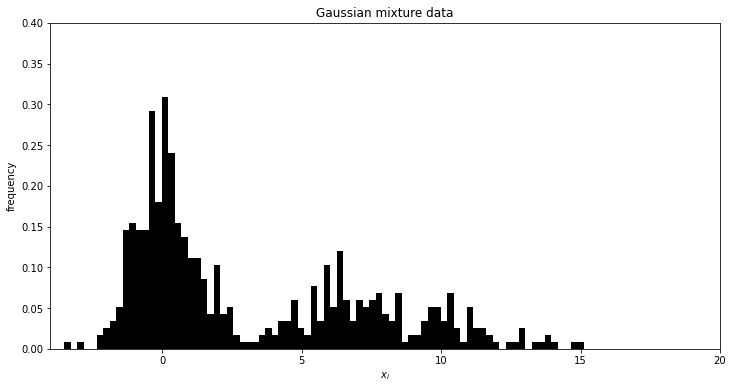

In [2]:
mu_exact = [0, 8]
sig_exact = [1, 3]
pi = 0.4 
n = 500

X = np.empty(shape=(n,2)) # x,z
for i in range(n):
    # get the component
    k = binomial(1, pi, 1)
    # sample from this component
    if k==0:
        X[i,:] = [normal(loc=mu_exact[0], scale=sig_exact[0], size=1), k]
    else:
        X[i,:] = [normal(loc=mu_exact[1], scale=sig_exact[1], size=1), k]

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(X[:,0], bins=80, color='k', density=True)
ax.set_xlim([-4,20])
ax.set_ylim([0,.4])
ax.set_title("Gaussian mixture data")
ax.set_xlabel(r"$x_i$")
ax.set_ylabel("frequency")


plt.show()


In [ ]:
def update_pi(k):
    """
        Sample from posterior conditional for component probability.

        k: index of the mixture component
    """
    N = x.shape[0]
    n = x[z==k]
    return beta(1+n, 1+(N-n))

def update_mu(k):
    """
        Sample from posterior conditional for component means.

        k: index of the mixture component
    """
    alpha = np.sum(x[z==k]) / (sigma2[k] + np.sum(z==k))
    beta = sigma2[k] / (sigma2[k] + np.sum(z==k))
    return normal(alpha, beta)

def update_sigma2(k):

    alpha = 1 + np.sum(z==k)
    beta = 1 + 0.5 * np.sum( (x[z==k] - mu[k])**2 )

    return exponential(scale=)

    pass

$$ p\left(\sigma_1^2|\ldots\right) \propto \frac{1}{\left( \sigma_2^2\right)^{\alpha'}} \exp\left( -\frac{\beta'}{\sigma_1^2}\right) $$ where $$ \alpha' = 1 + \sum_{n=1}^N \left(1-z^n\right),\; \beta' = 1+\frac{1}{2} \sum_{n=1}^N \left(1-z^n\right) \left(x^n - \mu_0\right)^2 $$